## Tranfer Learning with MobileNetV2

Welcome to the assignment, where you'll be using *transfer learning* on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

By the end of this assignment, you'll be able to:
- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pre-trained model to a new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy


### 1 - Packages


In [1]:
import matplotlib.pyplot as plt
import json 
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
os.getcwd()

'/workspace'

### 1.1 Create the Dataset and split it into Training and Validation Sets

When training and evaluating a deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call the `image_dataset_from_directory` to read from the directory and create both training and validation datasets.

If you are specifying a validation split, you'll also need to specify the `subset` argument. Just set the training set to `"subset='training'"` and the validation set to `"subset='validation'"`. 

You'll also set your seeds to match each other, so your training and validation sets don't overlap.


In [3]:
os.chdir(os.path.join(os.getcwd(), 'Chapter04-Convolutional-Neural-Networks',
                       'DeepConvolutional_Models-CaseStudies', 
                       'W2A2'))

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = 'dataset/'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size = BATCH_SIZE,
                                            image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                    subset="validation",
                                                    seed=42,
                                                    batch_size = BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


2026-01-16 06:06:01.632385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


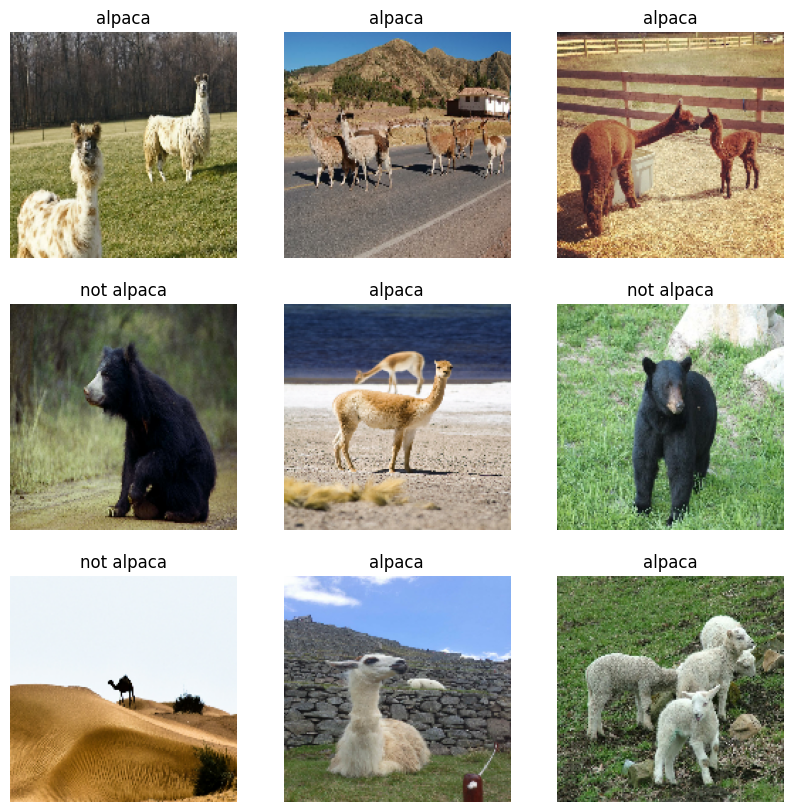

In [5]:
## Now let's take a look at the images from the training dataset
## Note: The original dataset has some mislabelled images in it as well

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2-Preprocess and Augment the Training Data

You may have encounted the `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in a data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically.  Autotune prompts tf.data to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm.The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them.  Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later. Ahh, so convenient!

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### E1 - data_augmenter
Implement a function for data augmentation. Use a Sequential keras model composed of 2 layers:
- RandomFlip('horizontal')
- RandomRotation(0.2)

In [7]:
## UNQ_C1
## GRADED FUNCTION: data_augmenter

def data_augmenter():
    """ 
    Create a Sequential model composed of 2 layers:
    Returns a Sequential model that performs data augmentation."""

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))  
    
    return data_augmentation


In [8]:
augmenter = data_augmenter()
assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


Take a look at how an image from the training set has been augmented with simple transformations:
From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from!


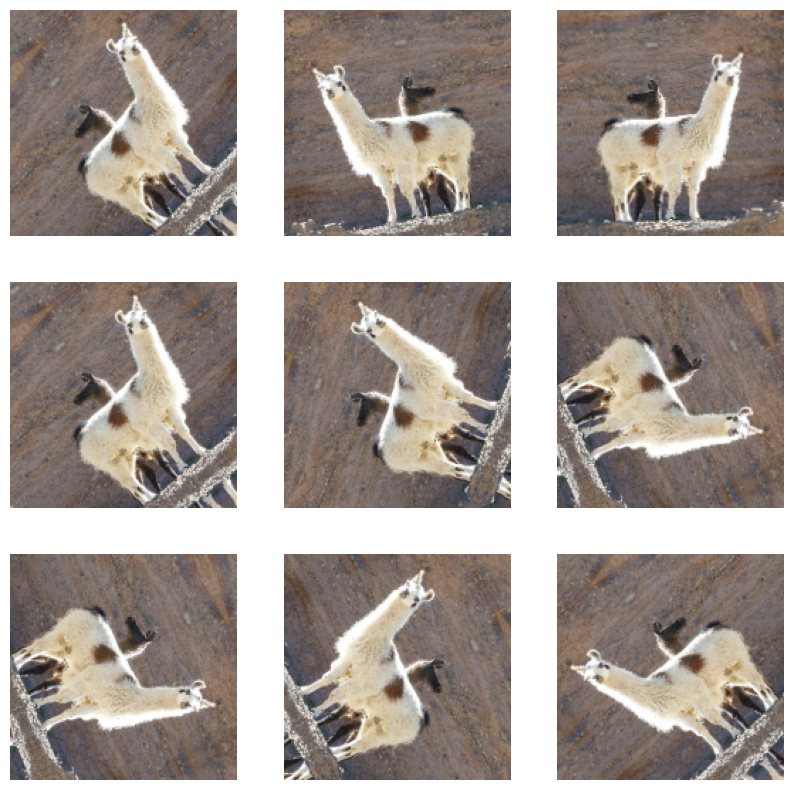

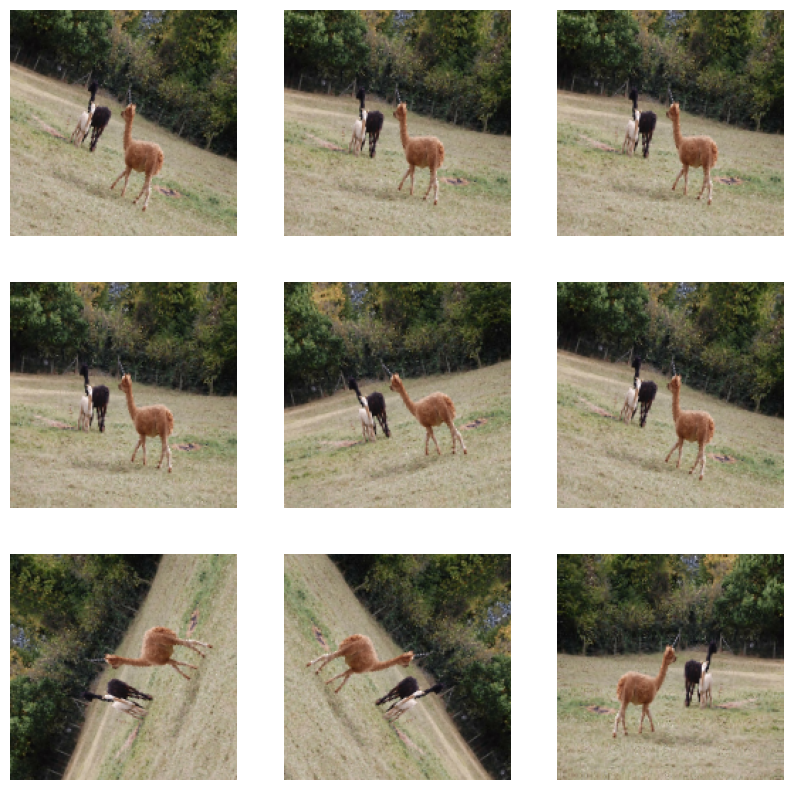

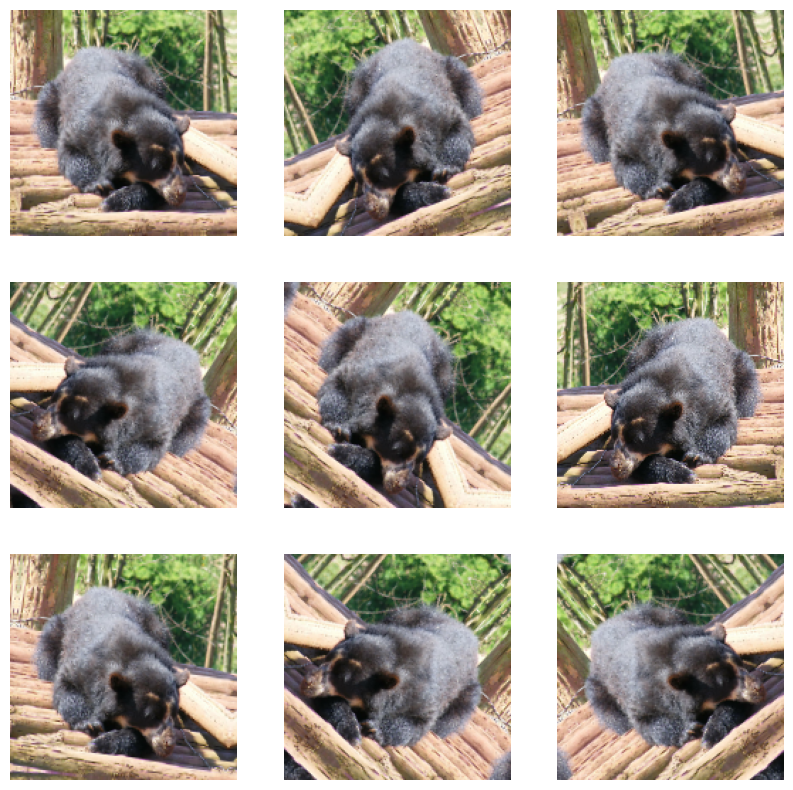

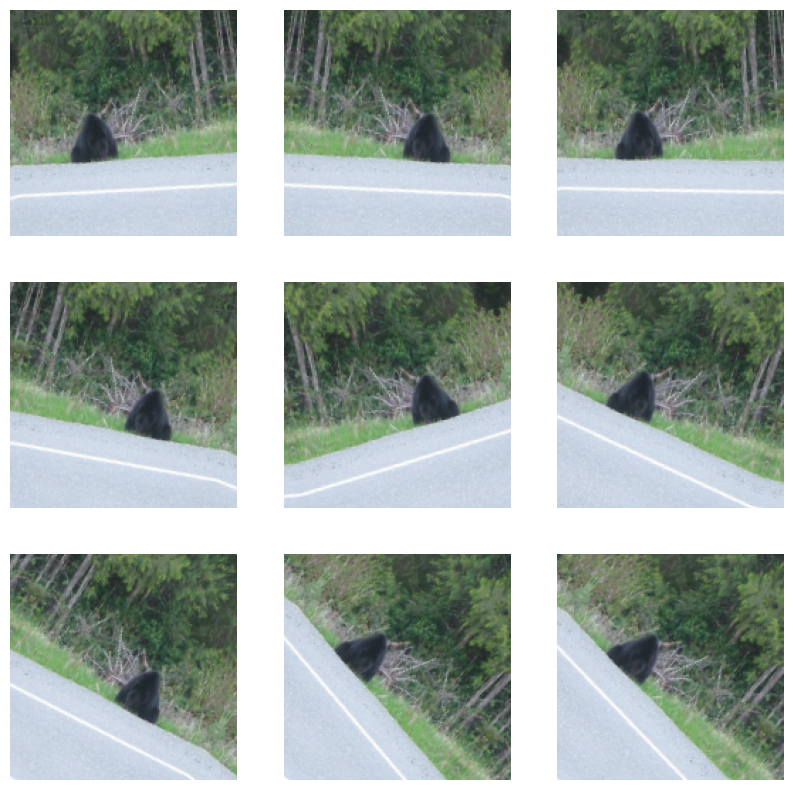

In [69]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(4):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), 
            training=True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")
    

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep(just in case you felt the urge to plot the model yourself, prepare for a long journey!), and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one.  The architecture has three defining characteristics:
- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottlenecks layers

### 3.1 - Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 uses depthwise separable convolutions as effective building blocks.  Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.
2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**


<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>


Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 



Let's try to train your base model using all the layers from the pretrained model.

Similarly to how you reuse the pretrained normalization values mobileNetV2 was trained on, you'll also load the pretrained weights from imageNet.  

By specifying `weights='imagenet'`, the weights are downloaded for imageNet. But for this lab, you'll load them locally from your workspace.

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights=base_model_path)

In [12]:
### print the model summary below to see all the model's layers, the shapes of their outputs, and the number of parameters in each layer, trainable and non-trainable.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
nb_layers = len(base_model.layers)
## Arrary indexing of the last two layers
## Let's learn the approaching of array indexing like this, e.g. last layer is len of layers -1
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [24]:
print(base_model.layers[-1].name)
print(base_model.layers[-2].name)

predictions
global_average_pooling2d


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


Now decode the predictions made by the model, Earlier, when you printed the shape of the batch, it would have returned (32, 1000). the number 32 refers to the batch size, and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:   


First the class number, then a human-readable label, and last the probability of the image belonging to that class.  You'll notice that there are two of these returned for each image in the batch - these the top probilities returned for that image.

In [22]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)


with open('imagenet_base_model/imagenet_class_index.json', ) as json_file:
    class_index = json.load(json_file)

In [23]:
## Function to decode the predictions
def decode_predictions(predictions, top=2):
    results = []
    for pred in predictions:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(class_index[str(i)]) + (pred[i], ) for i in top_indices]
        results.append(result)
    return results

decode_predictions = decode_predictions(pred.numpy(), top=2)
print(decode_predictions)



[[('n02454379', 'armadillo', 0.8928078), ('n02172182', 'dung_beetle', 0.024269098)], [('n02437312', 'Arabian_camel', 0.2954119), ('n02134084', 'ice_bear', 0.043125294)], [('n01616318', 'vulture', 0.075224765), ('n02130308', 'cheetah', 0.06773603)], [('n02437616', 'llama', 0.9813888), ('n02437312', 'Arabian_camel', 0.00090886967)], [('n02483362', 'gibbon', 0.16563395), ('n02509815', 'lesser_panda', 0.100415856)], [('n02133161', 'American_black_bear', 0.8799124), ('n02132136', 'brown_bear', 0.019821653)], [('n01518878', 'ostrich', 0.95788085), ('n02018795', 'bustard', 0.002906942)], [('n02437616', 'llama', 0.78146994), ('n02098286', 'West_Highland_white_terrier', 0.043964226)], [('n02410509', 'bison', 0.45431453), ('n02132136', 'brown_bear', 0.45169133)], [('n02133161', 'American_black_bear', 0.6910864), ('n02132136', 'brown_bear', 0.08774363)], [('n01518878', 'ostrich', 0.8796735), ('n02018795', 'bustard', 0.007729861)], [('n02437616', 'llama', 0.47192973), ('n02417914', 'ibex', 0.21382

There is a whole of labels here. some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classsification layer.  



### 3.2 - Layer Freezing with the Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">

In the next sections, you'll see how you can use a pre-trained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer, in this case the top layer is the prediction layer)
    * Set `include_top` in `base_model` to `False`
2. Add a new classifier layer
    * Train only on the layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary class 
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [72]:
## UNQ_C2
## GRADED FUNCTION



def alpaca_model(image_shape=IMG_SHAPE, data_augmentation=data_augmentation):
    """ 
    Define a tf.keras Model for binary classification out of the MobileNetV2 base model.
    
    Arguments:
    image_shape -- shape of the input images (height, width, channels)
    data_augmentation -- data augmentation function
    
    Returns:
    model -- a Keras Model instance
    """
    
    input_shape = image_shape + (3,)
    
    ### StART CODE HERE
    # Download weights automatically from ImageNet
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights=base_model_path)
    ### Freeze the base model by making it non-trainable
    base_model.trainable = False
    
    ## Create the input layer (same as the imageNet2 input shape)
    inputs = tf.keras.Input(shape=input_shape)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing 
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1)(x)
    
    ### END CODE HERE

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [73]:
## create new model using the data_augmentation function defined before
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [80]:
from test_utils import summary, comparator

alpaca_summary = [ ['InputLayer', [(None, 160, 160, 3)], 0], 
                  ['Sequential', (None, 160, 160, 3), 0], 
                  ['TFOpLambda', (None, 160, 160, 3), 0],
                  ['TFOpLambda', (None, 160, 160, 3), 0],
                  ['Functional', (None, 5, 5, 1280), 2257984],
                  ['GlobalAveragePooling2D', (None, 1280), 0],
                  ['Dropout', (None, 1280), 0, 0.2],
                  ['Dense', (None, 1), 1281, 'linear'] ]  #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [81]:

base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])



In [ ]:
### epochs to train the model
initial_epochs = 100
history = model2.fit(train_dataset,
                     epochs=initial_epochs,
                     validation_data=validation_dataset
                     )

Epoch 1/100


9/9 [==============================] - 4s 354ms/step - loss: 0.5966 - accuracy: 0.6756 - val_loss: 0.4884 - val_accuracy: 0.7385
Epoch 2/100
9/9 [==============================] - 3s 296ms/step - loss: 0.5656 - accuracy: 0.7176 - val_loss: 0.4772 - val_accuracy: 0.7385
Epoch 3/100
9/9 [==============================] - 3s 287ms/step - loss: 0.5704 - accuracy: 0.6947 - val_loss: 0.4702 - val_accuracy: 0.7538
Epoch 4/100
9/9 [==============================] - 3s 281ms/step - loss: 0.5544 - accuracy: 0.6985 - val_loss: 0.4598 - val_accuracy: 0.7692
Epoch 5/100
9/9 [==============================] - 3s 267ms/step - loss: 0.5904 - accuracy: 0.6565 - val_loss: 0.4544 - val_accuracy: 0.7538
Epoch 6/100
9/9 [==============================] - 3s 258ms/step - loss: 0.5578 - accuracy: 0.6794 - val_loss: 0.4460 - val_accuracy: 0.7538
Epoch 7/100
9/9 [==============================] - 3s 262ms/step - loss: 0.5427 - accuracy: 0.7366 - val_loss: 0.4373 - val_accuracy: 0.7692
Epoch 8/100
9/9 [========

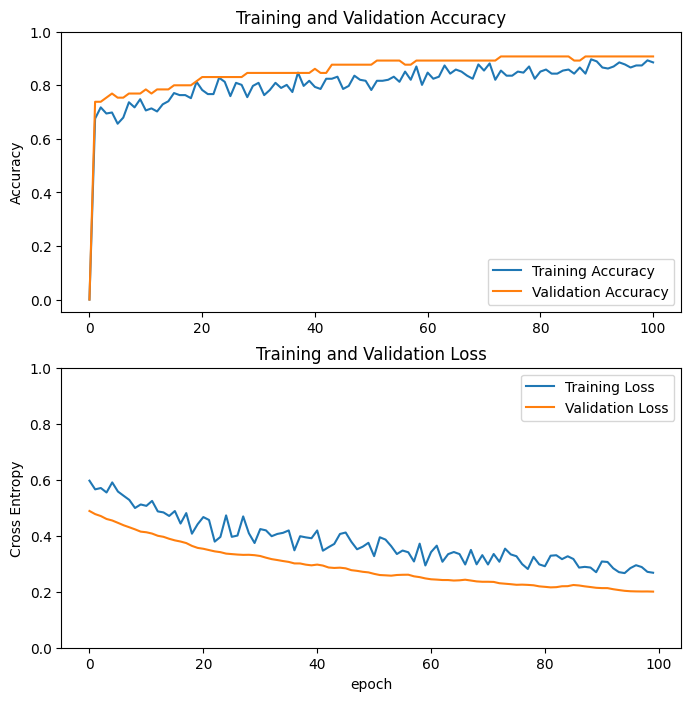

In [102]:
## plot the trainning and validtion accuracy/loss curves
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [86]:
class_names

['alpaca', 'not alpaca']

## 3.3 - Fine-tuning the Model

You could try fine-tuning the model by re-runing the optimizer in the last layers to improvce accuracy.  When you use a smaller learning rate, you take smaller steps to adopt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the final layers at the end of the network, and then re-training your model on final layers with a very low learning rate. Adapting your leanring rate to go over there layers in smaller steps can yield better results.


The intuition for what's happening: when the network is in its earlier stages, it trains on lower-level features, like edges and textures. In the later stages, more complex, high-level features like wispy hair or pointy ears begin to emerge.  For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.  

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.


Where the final layers actually is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved! 



In [ ]:

base_model = model2.layers[4]
base_model.trainable = True 

## let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

## Fine tune layers from this layer onwards
fine_tune_at = 120

## START CODE HERE
## Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
## ## Define a BinaryCrossentropy loss function with from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Use accuracy as evaluation metric
metrics = ['accuracy']
### END CODE HERE

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)


Number of layers in the base model:  154


In [101]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [96]:
initial_epochs = 10

In [103]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         validation_data=validation_dataset)

Epoch 1/15
9/9 [==============================] - 8s 458ms/step - loss: 0.2892 - accuracy: 0.8397 - val_loss: 0.1787 - val_accuracy: 0.9077
Epoch 2/15
9/9 [==============================] - 3s 338ms/step - loss: 0.2758 - accuracy: 0.8817 - val_loss: 0.1568 - val_accuracy: 0.9231
Epoch 3/15
9/9 [==============================] - 3s 323ms/step - loss: 0.2321 - accuracy: 0.8588 - val_loss: 0.1754 - val_accuracy: 0.9077
Epoch 4/15
9/9 [==============================] - 3s 325ms/step - loss: 0.2301 - accuracy: 0.8893 - val_loss: 0.1324 - val_accuracy: 0.9538
Epoch 5/15
9/9 [==============================] - 3s 333ms/step - loss: 0.2155 - accuracy: 0.9122 - val_loss: 0.1226 - val_accuracy: 0.9538
Epoch 6/15
9/9 [==============================] - 3s 318ms/step - loss: 0.2110 - accuracy: 0.9122 - val_loss: 0.1633 - val_accuracy: 0.9077
Epoch 7/15
9/9 [==============================] - 3s 320ms/step - loss: 0.1970 - accuracy: 0.9275 - val_loss: 0.1209 - val_accuracy: 0.9538
Epoch 8/15
9/9 [====

In [104]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

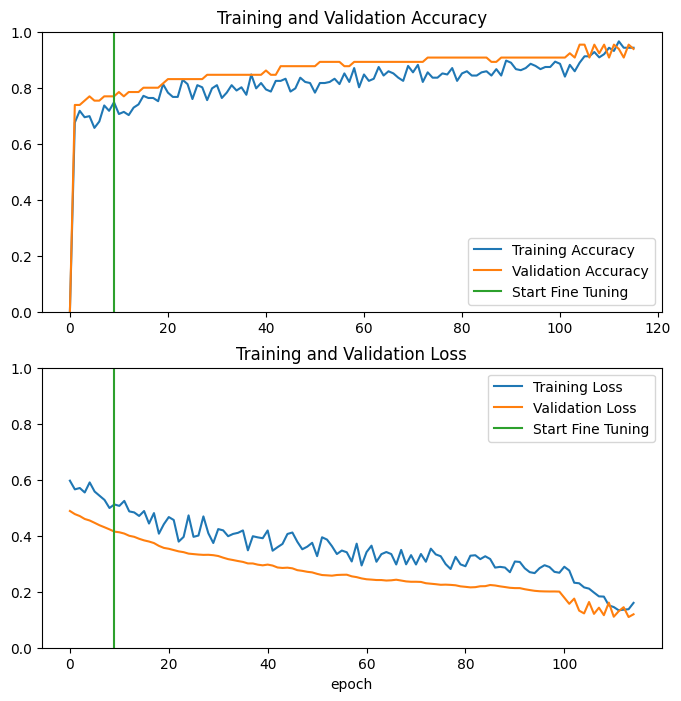

In [105]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**What you should remember:**
* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics ( like in batch norm layers) by setting training=False
* Fine-tuning the final layers of your model to captur high-level details near the end of the network and potentially improve accuracy